# Lecture 20 - Implied Volatility, Gamma hedging, Vega Hedging, FX options


## L20.1 Implied Volatility

Volatility cannot be observed directly from the stock price but we can estimate it using historical data. This estimate is, however, risky as conditions may chance and past volatility may not be representative of future price volatility of the company (the company or the market can change significantly from one time to another).

The Black Scholes model erroneously assumes a constant volatility which can result in significant hedging errors. 
However, there is a quantity called the implied volatility that sometimes helps. Suppose we know from the market that a non-divident paying stock is valued at 21, and that the price of a 3 month call option with strike 20 is 1.875 with a continuously compounded interest rate of 10%. We don't have the volatility but we have the option price, so we can find the volatility that gives us the option price. This volatility is called the **implied volatility**. Let's find the implied volatility in this case.

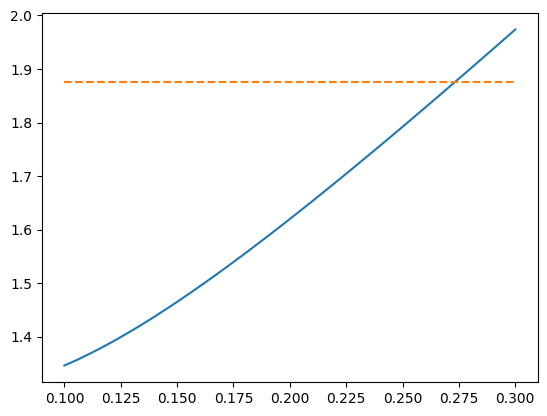

In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def blackScholesCall(T,S,sigma,K,r):
    d1 = (np.log(S/K)+(r+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
K = 20
T = 0.25
sigma = np.linspace(0.1,0.3,100)
S = 21
r = 0.06
V = 1.875
Vs = [blackScholesCall(T,S,sigma_,K,r) for sigma_ in sigma]

plt.plot(sigma,Vs,sigma,V*np.ones(100),'--')

In [3]:
#Or find it using a solver
from scipy.optimize import newton

def zero(sigma_):
    return blackScholesCall(T,S,sigma_,K,r) - V

print("Implied volatility: ", newton(zero, 0.2))

Implied volatility:  0.27305844610741603


The implied volatility can be interpreted to indicate the market opinion about the volatility of a particular stock. In practice, the implied volatilities change from one day to the next. 

One of the most frequently quoted risk measure is the so called VIX. The VIX is the implied volatility of the S&P 500 index (or options on the S&P 500) for the next 30 days and it has been called the fear index. It is often quoted and consulted when people want the gauge the riskiness of the current markets. Here is an interesting graph showing how it worked when Covid started, and the wars in Ukraine and Palestine. https://www.google.com/finance/quote/VIX:INDEXCBOE?sa=X&ved=2ahUKEwiih9rn6vP6AhWSYcAKHfXdBr4Q3ecFegQIKhAg&window=5Y

There might be situations where little trading is going on and the volatility is low, but the implied volatility may be very high (e.g., elections might be looming). One way to address the variability in the volatility is to introduce a deterministic time dependent volatility, $\sigma(t)$. This can be inserted into the Black Scholes equation and the Black-Scholes formulas still work but with the constant volatility replaced by the time average of the volatility:

$$\sqrt{\frac{1}{T-t}\int_t^T{\sigma(\tau)^2d\tau}}$$

Then, one can fit the volatility function to the implied volatilities for options with different expiration dates, basically,

$$\sqrt{\frac{1}{T-t}\int_t^T{\sigma(\tau)^2d\tau}} = \text{implied volatilities}$$

This is not a great solution though...

## L20.2 Volatility smiles and surfaces

Suppose we are looking at options on the same underlying asset with the same maturity but with several different stikes. The figure below shows a typical situation.

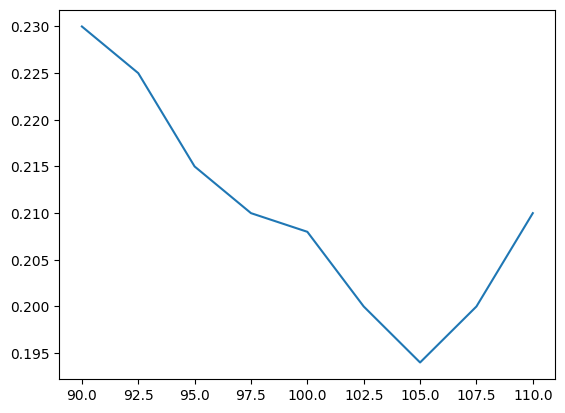

In [4]:
strikes = [90,92.5,95,97.5,100,102.5,105,107.5,110]
vols = [0.23, 0.225,0.215,0.21, 0.208,0.20, 0.194,0.20, 0.21]

plt.plot(strikes,vols)

What we see is inconsistency. Even though the expiration date is the same, we are not getting the same implied volatiltities as they differ by the strike. This shape is typical and it is called the volatility smile (although it is usually more like a smirk).

So, now we are in trouble when it comes to fitting a time varying volatility - which volatility should we use? One solution is to use a volatility surface.

The volatility surface $\sigma(t,S)$ is fitted so as to give the market price of each option when used in the Black-Scholes framework. This is possible and gives a dreadfully looking formulas for the volatilty surface as a function of implied volatilities at different maturities and strikes.

There are various problems with this approach, however. The market predictions of the volatilities usally do not come true. A better way is to use vega hedging and gamma hedging.

## L20.3 Vega and Gamma hedging

Recall that the vega is the sensitivity of the option value to volatility. If vega is high, that means that small changes in volatility can have a significant impact on the value of the option, and the opposite is the case if vega is low, i.e., changes in volatility have small impacts on the change of the price. It is thus worth something to make the vega low, and one way to do that is to vega hedge. The formula for the vega is

$$\text{Vega}^c = S\sqrt{T-t}N'(d_1)$$

Consider the option we were working with originally (let's use the implied vol for that option):

In [5]:
def blackScholesCallDelta(T,S,sigma,K,r):
    d1 = (np.log(S/K)+(r+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

K = 20
T = 0.25
sigma = 0.27305844610741603
S = 21
r = 0.06
V = blackScholesCall(T,S,sigma,K,r)

d1 = (np.log(S/K)+(r+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
vega = S*np.sqrt(T)*np.exp(-d1**2/2)/np.sqrt(2*3.1416)
print("Option value: ", V)
print("Delta: ",blackScholesCallDelta(T,S,sigma,K,r))
print("Vega: ", vega)
print("Sensitivity to 1% change in vol: ", vega*0.01/V)

#Another way to test the sensitivity:
print("Sensitivity to 1% change in vol direct: ",(blackScholesCall(T,S,sigma+0.01,K,r)-V)/V)

Option value:  1.8749999999999982
Delta:  0.7038450846562136
Vega:  3.62937270277789
Sensitivity to 1% change in vol:  0.019356654414815433
Sensitivity to 1% change in vol direct:  0.01942982881031414


So, this means that if we change the volatility by 1%, then the price of the option changes by almost 0.04, or about 2% of the option value. Now, we could easily be off in the volatility by 2-3%, so it makes sense to look into if we can reduce that uncertainty. We need to use another option to hedge the vega as we cannot hedge it by buying or selling the underlying asset. Here we need to be careful as this will also change our delta. In order to be delta neutral, the writer of the option would need to buy 0.7038 shares.

Suppose have another option on the same underlying, but now with a different strike, say, $K=22$, and different maturity, say $T=1.0$, and let's assume that the volatility is also different at $\sigma = 0.28$.

In [6]:
K = 22
T = 1
sigma = 0.28
S = 21
r = 0.06
V = blackScholesCall(T,S,sigma,K,r)

d1 = (np.log(S/K)+(r+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
vega = S*np.sqrt(T)*np.exp(-d1**2/2)/np.sqrt(2*3.1416)
print("Option value: ", V)
print("Delta: ",blackScholesCallDelta(T,S,sigma,K,r))
print("Vega: ", vega)
print("Sensitivity to 1% change in vol: ", vega*0.01/V)

Option value:  2.4657503687682514
Delta:  0.5746176452151823
Vega:  8.230805458258727
Sensitivity to 1% change in vol:  0.03338053017252663


In order to make our hedging portfolio vega neutral, we need to buy $\alpha$ options of the second kind so that

$$\text{vega}_1 - \alpha\text{vega}_2 = 0, \text{ or } 3.629 - 8.231\alpha = 0$$

or $\alpha = 0.4409$

Thus, we buy 0.4409 options of the second kind and we are now vega neutral. This will mess up our delta, as now our delta is

$$0.7038 - 0.4409 \times 0.5746 = 0.4505$$

Hence, we need to sell a few shares from our hedging portfolio (as we started out with 0.7038) to remain delta neutral. Let's take a look at the sensitivity in our portfolio now (ignoring the share position and cash holdings as they do not change with $\sigma$)

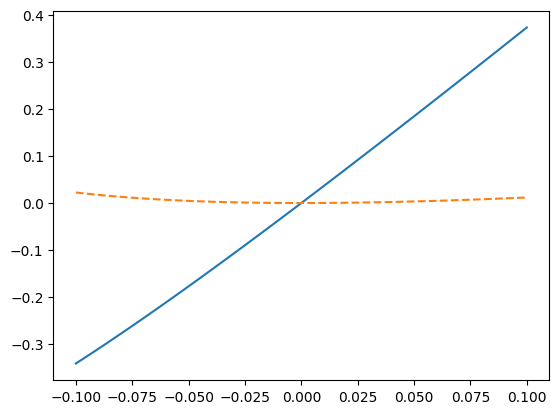

In [7]:
K = 20
T = 0.25
sigma1 = 0.27305844610741603
delta_sigma = np.linspace(-0.1,0.1,100)
S = 21
r = 0.06
V1_base = blackScholesCall(T,S,sigma1,K,r)
V1 = [blackScholesCall(T,S,sigma1+ds,K,r) for ds in delta_sigma]

K = 22
T = 1
sigma2 = 0.28
S = 21
r = 0.06
V2_base = blackScholesCall(T,S,sigma2,K,r)
V2 = np.array([blackScholesCall(T,S,sigma2+ds,K,r) for ds in delta_sigma])

plt.plot(delta_sigma,V1-V1_base, delta_sigma, V1 - 0.4409*V2 - (V1_base-0.4409*V2_base),'--')


..much better. What about gamma hedging? This is also important, but the procedure is the same. If we want to gamma hedge, we go throught the same process as above, buy another option into our hedging portfolio and adjust the delta by buying or selling shares. If we want to make our portfolio both gamma and vega neutral, we need to buy two options and solve two equations in two unknowns, to ensure that our total vega is 0 and our total gamma is 0. That is a very good way to hedge options if enough are available on the market as they reduce the hedging frequency and the model risk.

## L20.4 FX options

We saw Foreign Exchange (FX) forward contract before, but there, we had to deal with two risk free interest rates, one in each currency. Now, let´s take a look at derivatives on currency. First, we need to understand what it means. 

A currency call option is the right, but not the obligation, to purchase a certain amount of a currency A for a certain amount of currency B, e.g., the right, but not the obligation, to purchase \\$100_000 for EUR 100_000, etc. Put options are similar, but just give the right to sell one currency for another at a given exchange rate. The implied exchange rate plays the role of the strike (in this case it is 1.0000), and the payoff of the call option is then:

$$EUR 100,000*max(X - 1,0)$$

where $X$ is the number of dollars per 1 EUR, or the exchange rate. The random element here is $X$.

We now move into some formalities. We assume the following dynamics

$$dX_t = X\alpha dt + X\sigma dW$$
$$dB_d = r_dB_ddt$$
$$dB_f = r_fB_fdt$$

where $B_d$ is the domestic risk free asset and $B_f$ is the foreign risk free asset. We cannot just go ahead and use the Black Scholes asset and ignore the foreign risk free asset. This is because the replicating portfolio has the foreign asset in it. The replicating porfolio is in fact just the domestic cash (as before) together with foreign cash. We thus have to define a domestic asset called $\bar{B}_f$ which is simply the foreign asset evaluated in the domestic currency, i.e.,

$$\bar{B}_f = XB_f$$

We can apply the Ito formula, using the dynamics above, to find that

$$d\bar{B}_f = \bar{B}_f(\alpha +r_f) dt + \bar{B}_f\sigma dW$$

Now we are back in business, and we can use the Girsasnov Theorem to change the measure and write

$$d\bar{B}_f = \bar{B}_f r_d dt + \bar{B}_f\sigma dW'$$

We also have that

$$X = \frac{\bar{B}_f}{B_d}$$

so, we can use Ito again to find the dynamics of $X$ of under the Q measure, and we get

$$dX_t = X(r_d - r_f) dt + X\sigma dW'$$

We are interesting in valuing call and put options, e.g., $max(X - 1,0)$, and we see that $X$ now plays the role of $S$ before, and that we can use the Black Scholes formulas but with $r$ replaced by $r_d-r_f$. For any European derivative, we always have

$$V_t = e^{-r_d(T-t)}E^Q\left[\Phi(X_T)\right]$$

and in the case of a call option and a put option, we have

$$V^c(t,X) = e^{-r_f(T-t)}XN(d_1) - Ke^{-r_d(T-t)}N(d_2)$$

$$V^p(t,X) = -e^{-r_f(T-t)}XN(-d_1) + Ke^{-r_d(T-t)}N(-d_2). $$

where $N$ is the cumulative distribution function for a standard normal variable, and 

$$d_1 = \frac{\log(X/K) + (r_d-r_f+\frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}}$$

and

$$d_2 = d_1 -\sigma \sqrt{T-t}.$$

Let's do one example. Consider a 4 month European call option to buy GBP for USD. Assume the current exchange rate is 1.6000, the risk free rate in USD is 0.08, the risk free rate in GBP is 0.11 and the strike is 1.6000. The volatility is 14.1%. What is the value of a call option?

In [8]:
from scipy.stats import norm
import numpy as np

def blackScholesFXCall(T,X,sigma,K,rd,rf):
    d1 = (np.log(X/K)+(rd - rf+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return np.exp(-rf*T)*X*norm.cdf(d1)-K*np.exp(-rd*T)*norm.cdf(d2)

K = 1.6
X0 = 1.6
T = 1/3.0
sigma = 0.141
rd = 0.08
rf = 0.11
blackScholesFXCall(T,X0,sigma,K,rd,rf)

0.042957730192595855

## HW 20

1. Suppose a call option has expiry of 6 months, strike price of 99, current value of the underlying is 101, risk neutral interest of 6%. Suppose further that the option value in the market is 9.678. Find the implied volatility of the option.

2. Suppose you have written 10 call options with exercise price 50, current price of 50, maturity of 65 days ($T$ = 65/365), volatility of 25% and continously compounded risk free rate of 6%. Find

a. The value of the option

b. The delta and gamma of the option, and thus the number of shares in your hedging portfolio

c. Suppose there is another option (B) in the market with a delta of 0.2965 and gamma of 0.0529. Find the number of B options that you would need to buy to make the hedging portfolio gamma neutral and how the number of shares in the hedging portfolio would need to be adjusted to keep the portfolio delta neutral. 

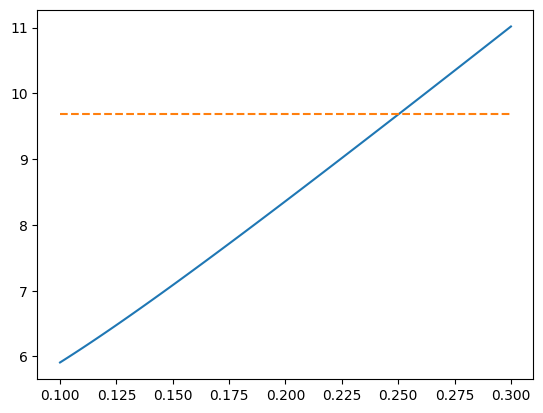

In [11]:
def blackScholesCall(T,S,sigma,K,r):
    d1 = (np.log(S/K)+(r+sigma**2/2.0)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
K = 99
T = 0.5
sigma = np.linspace(0.1,0.3,100)
S = 101
r = 0.06
V = 9.678
Vs = [blackScholesCall(T,S,sigma_,K,r) for sigma_ in sigma]

plt.plot(sigma,Vs,sigma,V*np.ones(100),'--')


In [13]:
norm.cdf(0.0485)

0.519341117778337